D:\Programming\EEG\directional.py:39: RuntimeWarning: invalid value encountered in scalar divide
  return float(iv(nu + 1, kappa) / (iv(nu, kappa) + 1e-12))



=== vMF clusters ===
counts: [ 64868 118754  65659 110719]
kappas: [41.946 58.888 42.336 57.173]

=== IFE fit ===
chosen rank r: 3
IC values: {1: np.float64(-20.3816), 2: np.float64(-20.6483), 3: np.float64(-20.7768)}
              coef      estimate
0      A:intercept -2.644111e-01
1    A:sex(male=1) -2.644111e-01
2  A:age(centered)  1.850878e+00
3     A:task(rest) -2.644111e-01
4        B:ToD_sin  6.086428e-09
5        B:ToD_cos -3.912926e-07
6         Z:vMF_p1 -6.611218e-02
7         Z:vMF_p2 -6.609656e-02
8         Z:vMF_p3 -6.611003e-02
9         Z:vMF_p4 -6.609236e-02


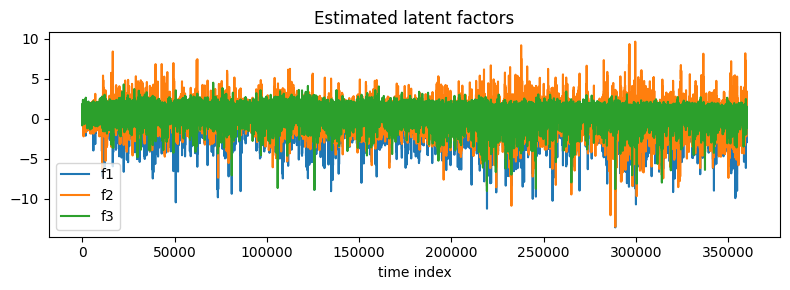


P(sex = male | data, model) = 1.0
ToD estimates (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [1]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io_utils import load_subject_sessions, pick_channel_columns
from directional import row_normalize, spherical_kmeans, estimate_vmf_params
from panel import build_response_logpower, build_A_block, build_B_block_time_of_day, build_Z_block
from ife import ife_ic_bai_ng
from impute import posterior_sex_probability, estimate_time_of_day

def main():
    # ---- config ----
    CHANNELS_TO_USE = 32
    K = 4
    RANK_GRID = [1, 2, 3]

    files = [
        "./data/subject_0_day1_morning.csv",
        "./data/subject_0_day1_afternoon.csv",
        "./data/subject_0_day2_morning.csv",
        "./data/subject_0_day2_afternoon.csv"
    ]

    # ---- load ----
    df = load_subject_sessions([Path(p) for p in files])
    ch_cols = pick_channel_columns(df, CHANNELS_TO_USE)
    X = df[ch_cols].to_numpy(float)                 # (T,C)
    sessions = df["session"].astype(str).tolist()
    T, C = X.shape

    # ---- vMF-like features ----
    Y_dir = row_normalize(X)
    mu, labels = spherical_kmeans(Y_dir, K=K, iters=30, seed=42)
    kappas, post = estimate_vmf_params(Y_dir, mu, labels)
    Z_t = build_Z_block(post)

    # ---- panel ----
    y_it = build_response_logpower(X)               # (N=C, T)
    A_t = build_A_block(T, sex_male1=1.0, age_years=23.0, task_rest1=1.0)
    B_t, M_t = build_B_block_time_of_day(sessions)

    # Example missingness: mark Day2 ToD missing
    is_day2 = np.array(["day2" in s.lower() for s in sessions])
    M_t[is_day2, :] = 0

    # ---- IFE (rank selection + fit) ----
    best_r, ic_vals, fits = ife_ic_bai_ng(y_it, A_t, B_t, Z_t, M_t, r_grid=RANK_GRID)
    fit = fits[best_r]

    # ---- reports ----
    coef_names = (
        [f"A:{n}" for n in ["intercept", "sex(male=1)", "age(centered)", "task(rest)"]]
        + [f"B:ToD_{n}" for n in ["sin", "cos"]]
        + [f"Z:vMF_p{k+1}" for k in range(Z_t.shape[1])]
    )
    beta_df = pd.DataFrame({"coef": coef_names, "estimate": fit.beta})
    print("\n=== vMF clusters ===")
    print("counts:", np.bincount(labels, minlength=K))
    print("kappas:", np.round(kappas, 3))

    print("\n=== IFE fit ===")
    print("chosen rank r:", fit.rank_r)
    print("IC values:", {k: round(v, 4) for k, v in ic_vals.items()})
    print(beta_df)

    # latent factors
    plt.figure(figsize=(8, 3))
    for j in range(fit.rank_r):
        plt.plot(fit.F[:, j], label=f"f{j+1}")
    plt.legend()
    plt.title("Estimated latent factors")
    plt.xlabel("time index")
    plt.tight_layout()
    plt.show()

    # ---- post-fit: sex probability (demo) ----
    p_male = posterior_sex_probability(y_it, fit, A_t, B_t, Z_t, M_t, sex_col_idx_in_A=1, prior_pi=0.5)
    print("\nP(sex = male | data, model) =", p_male)

    # ---- (optional) estimate ToD if missing ----
    idx_sin = A_t.shape[1]          # position of ToD_sin in full beta
    idx_cos = idx_sin + 1           # position of ToD_cos in full beta

    tau_hat = estimate_time_of_day(
        y_it, fit, A_t,
        B_t_other=np.zeros((T, 0)),  # no other B columns in this example
        Z_t=Z_t,
        beta_idx_sin=idx_sin, beta_idx_cos=idx_cos,
        omega=2 * np.pi / 24.0, grid_minutes=10
    )
    print("ToD estimates (first 10):", np.round(tau_hat[:10], 2))

if __name__ == "__main__":
    main()
